# Is Fandango Still Inflating Ratings?

In October 2015, Walt Hickey from FiveThirtyEight published a popular article where he presented strong evidence which suggest that Fandango's movie rating system was biased and dishonest. In this project, we'll analyze more recent movie ratings data to determine whether there has been any change in Fandango's rating system after Hickey's analysis.

## Understanding the data
We'll work with two samples of movie ratings:the data in one sample was collected previous to Hickey's analysis, while the other sample was collected after. Let's start by reading in the two samples (which are stored as CSV files) and getting familiar with their structure.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.options.display.max_columns = 100  # Avoid having displayed truncated output

previous = pd.read_csv('fandango_score_comparison.csv')
after = pd.read_csv('movie_ratings_16_17.csv')

previous.head(3)

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,Metacritic_norm,Metacritic_user_nom,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,3.30,3.55,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,3.35,3.75,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,3.20,4.05,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5


In [3]:
previous.columns

Index(['FILM', 'RottenTomatoes', 'RottenTomatoes_User', 'Metacritic',
       'Metacritic_User', 'IMDB', 'Fandango_Stars', 'Fandango_Ratingvalue',
       'RT_norm', 'RT_user_norm', 'Metacritic_norm', 'Metacritic_user_nom',
       'IMDB_norm', 'RT_norm_round', 'RT_user_norm_round',
       'Metacritic_norm_round', 'Metacritic_user_norm_round',
       'IMDB_norm_round', 'Metacritic_user_vote_count', 'IMDB_user_vote_count',
       'Fandango_votes', 'Fandango_Difference'],
      dtype='object')

In [4]:
previous_fandango = previous.loc[:,['FILM','Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes', 'Fandango_Difference']].copy()
previous_fandango.head(3)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5


In [5]:
after_fandango = after.loc[:,['movie', 'year', 'fandango']].copy()
after_fandango.head(3)

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0


Our goal is to determine whether there has been any change in Fandango's rating system after Hickey's analysis. The population of interest for our analysis is made of all the movie ratings stored on Fandango's website, regardless of the releasing year.

Because we want to find out whether the parameters of this population changed after Hickey's analysis, we're interested in sampling the population at two different periods in time — previous and after Hickey's analysis — so we can compare the two states.

The data we're working with was sampled at the moments we want: one sample was taken previous to the analysis, and the other after the analysis. We want to describe the population, so we need to make sure that the samples are representative, otherwise we should expect a large sampling error and, ultimately, wrong conclusions.

From Hickey's article and from the README.md of the data set's repository, we can see that he used the following sampling criteria:

The movie must have had at least 30 fan ratings on Fandango's website at the time of sampling (Aug. 24, 2015).
The movie must have had tickets on sale in 2015.
The sampling was clearly not random because not every movie had the same chance to be included in the sample — some movies didn't have a chance at all (like those having under 30 fan ratings or those without tickets on sale in 2015). It's questionable whether this sample is representative of the entire population we're interested to describe. It seems more likely that it isn't, mostly because this sample is subject to temporal trends — e.g. movies in 2015 might have been outstandingly good or bad compared to other years.

The sampling conditions for our other sample were (as it can be read in the README.md of the data set's repository):

The movie must have been released in 2016 or later.
The movie must have had a considerable number of votes and reviews (unclear how many from the README.md or from the data).
This second sample is also subject to temporal trends and it's unlikely to be representative of our population of interest.

Both these authors had certain research questions in mind when they sampled the data, and they used a set of criteria to get a sample that would fit their questions. Their sampling method is called purposive sampling (or judgmental/selective/subjective sampling). While these samples were good enough for their research, they don't seem too useful for us.

## Changing the goal of our analysis

At this point, we can either collect new data or change our the goal of our analysis. We choose the latter and place some limitations on our initial goal.

Instead of trying to determine whether there has been any change in Fandango's rating system after Hickey's analysis, our new goal is to determine whether there's any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. This new goal should also be a fairly good proxy for our initial goal.

## Isolating the Samples We Need

With this new research goal, we have two populations of interest:

All Fandango's ratings for popular movies released in 2015.
All Fandango's ratings for popular movies released in 2016.
We need to be clear about what counts as popular movies. We'll use Hickey's benchmark of 30 fan ratings and count a movie as popular only if it has 30 fan ratings or more on Fandango's website.

Although one of the sampling criteria in our second sample is movie popularity, the sample doesn't provide information about the number of fan ratings. We should be skeptical once more and ask whether this sample is truly representative and contains popular movies (movies with over 30 fan ratings).

One quick way to check the representativity of this sample is to sample randomly 10 movies from it and then check the number of fan ratings ourselves on Fandango's website. Ideally, at least 8 out of the 10 movies have 30 fan ratings or more.

In [6]:
after_fandango.sample(10,random_state=1)

,movie,year,fandango
108,Mechanic: Resurrection,2016,4.0
206,Warcraft,2016,4.0
106,Max Steel,2016,3.5
107,Me Before You,2016,4.5
51,Fantastic Beasts and Where to Find Them,2016,4.5
33,Cell,2016,3.0
59,Genius,2016,3.5
152,Sully,2016,4.5
4,A Hologram for the King,2016,3.0
31,Captain America: Civil War,2016,4.5


Above we used a value of 1 as the random seed. This is good practice because it suggests that we weren't trying out various random seeds just to get a favorable sample.

As of April 2018, these are the fan ratings we found:

|**Movie**|**Fan Ratings**
|---      |---|
|Mechanic: Resurrection|2247|
|Warcraft|7271|
|Max Steel|493|
|Me Before You|5263|
|Fantastic Beasts and Where to Find Them|13400|
|Cell|17|
|Genius|127|
|Sully|11877|
|A Hologram for the King|500|
|Captain America: Civil War|35057|

90% of the movies in our sample are popular. This is enough and we move forward with a bit more confidence.

Let's also double-check the other data set for popular movies. The documentation states clearly that there're only movies with at least 30 fan ratings, but it should take only a couple of seconds to double-check here.

In [7]:

sum(previous_fandango['Fandango_votes'] < 30)

0


If you explore the two data sets, you'll notice that there are movies with a releasing year different than 2015 or 2016. For our purposes, we'll need to isolate only the movies released in 2015 and 2016.

Let's start with Hickey's data set and isolate only the movies released in 2015. There's no special column for the releasing year, but we should be able to extract it from the strings in the FILM column.

In [8]:
previous_fandango.head(2)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5


In [9]:
previous_fandango['Year'] = previous_fandango['FILM'].str[-5:-1]
previous_fandango.head(2)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,Year
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5,2015
1,Cinderella (2015),5.0,4.5,12640,0.5,2015


In [10]:
previous_fandango['Year'].value_counts()


2015    129
2014     17
Name: Year, dtype: int64

In [11]:
fandango_2015 = previous_fandango[previous_fandango['Year']=='2015'].copy()
fandango_2015['Year'].value_counts()

2015    129
Name: Year, dtype: int64

Great, now let's isolate the movies in the next data set.

In [12]:
    after_fandango.head(2)

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5


In [13]:
after_fandango['year'].value_counts()

2016    191
2017     23
Name: year, dtype: int64

In [14]:
fandango_2016 = after_fandango[after_fandango['year']==2016].copy()
fandango_2016['year'].value_counts()

2016    191
Name: year, dtype: int64

## Comparing Distribution Shapes for 2015 and 2016

Our aim is to figure out whether there's any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. One way to go about is to analyze and compare the distributions of movie ratings for the two samples.

We'll start with comparing the shape of the two distributions using kernel density plots. We'll use the FiveThirtyEight style for the plots.

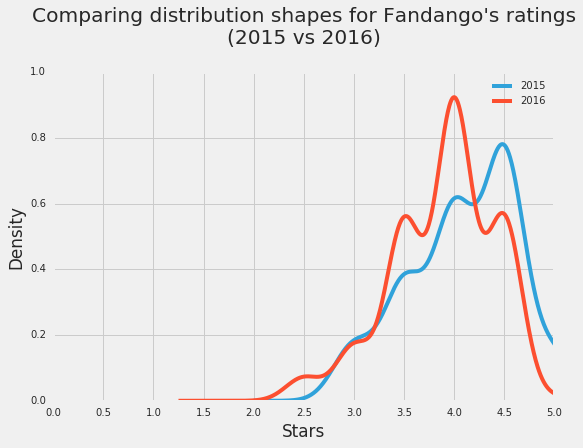

In [15]:
%matplotlib inline
plt.style.use('fivethirtyeight')

fandango_2015['Fandango_Stars'].plot.kde(label = '2015', legend = True, figsize = (8,5.5))
fandango_2016['fandango'].plot.kde(label = '2016', legend = True)

plt.title("Comparing distribution shapes for Fandango's ratings\n(2015 vs 2016)",
          y = 1.07) # the `y` parameter pads the title upward
plt.xlabel('Stars')
plt.xlim(0,5) # because ratings start at 0 and end at 5
plt.xticks(np.arange(0,5.1,.5))
plt.show()

Two aspects are striking on the figure above:

- Both distributions are strongly left skewed.
- The 2016 distribution is slightly shifted to the left relative to the 2015 distribution.

The left skew suggests that movies on Fandango are given mostly high and very high fan ratings. Coupled with the fact that Fandango sells tickets, the high ratings are a bit dubious. It'd be really interesting to investigate this further — ideally in a separate project, since this is quite irrelevant for the current goal of our analysis.

The slight left shift of the 2016 distribution is very interesting for our analysis. It shows that ratings were slightly lower in 2016 compared to 2015. This suggests that there was a difference indeed between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. We can also see the direction of the difference: the ratings in 2016 were slightly lower compared to 2015.

## Comparing Relative Frequencies
It seems we're following a good thread so far, but we need to analyze more granular information. Let's examine the frequency tables of the two distributions to analyze some numbers. Because the data sets have different numbers of movies, we normalize the tables and show percentages instead.

In [16]:
print("2015"+"\n"+"-"*16)
fandango_2015['Fandango_Stars'].value_counts(normalize=True).sort_index()*100

2015
----------------


3.0     8.527132
3.5    17.829457
4.0    28.682171
4.5    37.984496
5.0     6.976744
Name: Fandango_Stars, dtype: float64

In [17]:
print("2016"+"\n"+"-"*16)
fandango_2016['fandango'].value_counts(normalize=True).sort_index()*100

2016
----------------


2.5     3.141361
3.0     7.329843
3.5    24.083770
4.0    40.314136
4.5    24.607330
5.0     0.523560
Name: fandango, dtype: float64

In 2016, very high ratings (4.5 and 5 stars) had significantly lower percentages compared to 2015. In 2016, under 1% of the movies had a perfect rating of 5 stars, compared to 2015 when the percentage was close to 7%. Ratings of 4.5 were also more popular in 2015 — there were approximately 13% more movies rated with a 4.5 in 2015 compared to 2016.

The minimum rating is also lower in 2016 — 2.5 instead of 3 stars, the minimum of 2015. There clearly is a difference between the two frequency distributions.

For some other ratings, the percentage went up in 2016. There was a greater percentage of movies in 2016 that received 3.5 and 4 stars, compared to 2015. 3.5 and 4.0 are high ratings and this challenges the direction of the change we saw on the kernel density plots.

## Determining the Direction of the Change
Let's take a couple of summary metrics to get a more precise picture about the direction of the change. In what follows, we'll compute the mean, the median, and the mode for both distributions and then use a bar graph to plot the values.

In [19]:
mean_2015 = fandango_2015['Fandango_Stars'].mean()
mean_2016 = fandango_2016['fandango'].mean()

median_2015 = fandango_2015['Fandango_Stars'].median()
median_2016 = fandango_2016['fandango'].median()

mode_2015 = fandango_2015['Fandango_Stars'].mode()[0]
mode_2016 = fandango_2016['fandango'].mode()[0]

summary = pd.DataFrame()
summary['2015'] = [mean_2015,median_2015,mode_2015]
summary['2016'] = [mean_2016,median_2016,mode_2016]
summary.index = ['mean','median','mode']
summary

,2015,2016
mean,4.085271,3.887435
median,4.000000,4.000000
mode,4.500000,4.000000


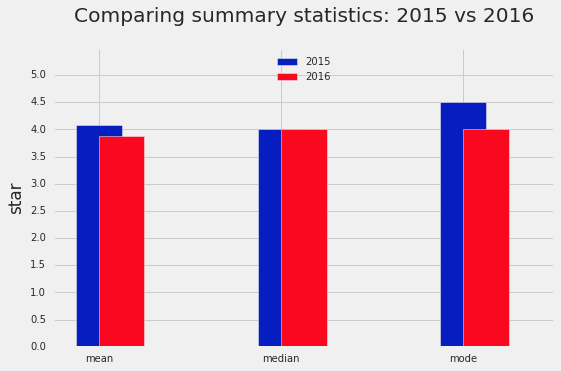

In [24]:
plt.style.use('fivethirtyeight')
summary['2015'].plot.bar(align='center',width=0.25,label='2015',color='#061ebf',figsize=(8,5))
summary['2016'].plot.bar(align='edge',width=0.25,label='2016',color='#fa0720',rot=0)


plt.title('Comparing summary statistics: 2015 vs 2016', y = 1.07)
plt.ylabel('star')
plt.ylim(0,5.5)
plt.yticks(np.arange(0,5.1,.5))
plt.legend(framealpha = 0, loc = 'upper center')
plt.show()



The mean rating was lower in 2016 with approximately 0.2. This means a drop of almost 5% relative to the mean rating in 2015.

In [25]:
(summary.loc['mean'][0] - summary.loc['mean'][1]) / summary.loc['mean'][0]

0.04842683568951993

While the median is the same for both distributions, the mode is lower in 2016 by 0.5. Coupled with what we saw for the mean, the direction of the change we saw on the kernel density plot is confirmed: on average, popular movies released in 2016 were rated slightly lower than popular movies released in 2015.